In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

# Training Set
TRAINING_DIR = "/gdrive/My Drive/Colab Notebooks/project-checkmate/03_split_categorized_samples/01_training/"
training_datagen = ImageDataGenerator(rescale = 1./255,
                                      #rotation_range=30,
                                      width_shift_range=0.1,
                                      height_shift_range=0.1,
                                      #shear_range=0.1,
                                      zoom_range=0.1,
                                      horizontal_flip=True,
                                      vertical_flip=True,
                                      fill_mode='nearest')
train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       target_size=(50,50),
	                                                     class_mode='categorical',
                                                       batch_size=100)

# Validation Set
VALIDATION_DIR = "/gdrive/My Drive/Colab Notebooks/project-checkmate/03_split_categorized_samples/02_validation/"
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
	                                                            target_size=(50,50),
	                                                            class_mode='categorical',
	                                                            batch_size=100)

# Define callback functions
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.9999):
      print("\nReached 99.99% accuracy so cancelling training!")
      self.model.stop_training = True

myCallbacksList = [myCallback()]

# Define model
model = tf.keras.models.Sequential([
    # Input shape = 50x50 RGB color image
    # 1st Convolutional Neural Network (CNN)
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, input_shape=(50, 50, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    # 2nd Convolutional Neural Network (CNN)
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),

    # 3rd Convolutional Neural Network (CNN)
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),

    # 4th Convolutional Neural Network (CNN)
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(2,2),

    # Flatten the results to feed into a Dense Neural Network (DNN)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),

    # 512-neuron DNN
    tf.keras.layers.Dense(512, activation=tf.nn.relu),

    # Softmax Output Layer (3 categories)
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model.fit(x=train_generator,
                    epochs=1000,
                    validation_data=validation_generator,
                    verbose=2,
                    callbacks=myCallbacksList)

# Store trained model to h5 file
model_filename = "/gdrive/My Drive/Colab Notebooks/project-checkmate/04_training/model_13.h5"
#model_10 was best curve at epoch=~34
model.save(model_filename)

Found 800 images belonging to 3 classes.
Found 544 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
________________________________________

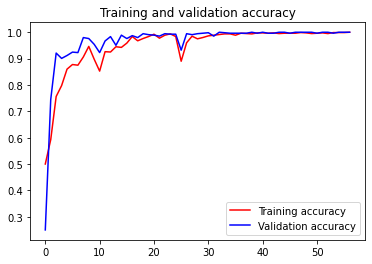

<Figure size 432x288 with 0 Axes>

In [3]:
# Plot Training vs. Validation accuracy with respect to number of epochs
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

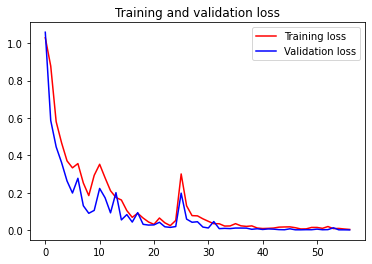

<Figure size 432x288 with 0 Axes>

In [4]:
# Plot Training vs. Validation loss with respect to number of epochs
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()

In [5]:
# Load model information
loaded_model = tf.keras.models.load_model(model_filename)

# Sample predictions
import numpy as np
from keras.preprocessing import image

# Predicting black pieces
img = image.load_img("/gdrive/My Drive/Colab Notebooks/project-checkmate/03_split_categorized_samples/02_validation/black/00-0-2.jpg", target_size=(50, 50))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
new_input = np.vstack([x])
prediction = np.round(loaded_model.predict(new_input))
print(prediction) # [[1. 0. 0.]]

# Predicting empty pieces
img = image.load_img("/gdrive/My Drive/Colab Notebooks/project-checkmate/03_split_categorized_samples/02_validation/empty/00-3-7.jpg", target_size=(50, 50))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
new_input = np.vstack([x])
prediction = np.round(loaded_model.predict(new_input))
print(prediction) # [[0. 1. 0.]]

# Predicting white pieces
img = image.load_img("/gdrive/My Drive/Colab Notebooks/project-checkmate/03_split_categorized_samples/02_validation/white/00-0-4.jpg", target_size=(50, 50))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
new_input = np.vstack([x])
prediction = np.round(loaded_model.predict(new_input))
print(prediction) # [[0. 0. 1.]]

Using TensorFlow backend.


[[1. 0. 0.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
